<a href="https://colab.research.google.com/github/sosososoyoen/hh_plus_ai_3/blob/main/work%20/%EA%B8%B0%EB%B3%B8_MNIST_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [22]:
# 이미지 데이터를 Tensor 형태로 변환! => 1 x 28 x 28
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


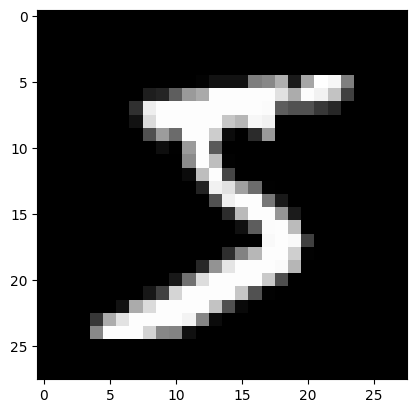

In [42]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [24]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)



In [25]:
# 테스트 데이터 로드
testset = torchvision.datasets.MNIST(
    root = './data',
    train=False,
    download=True,
    transform=transform
)

#테스트 로더
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [6]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [26]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

#퍼셉트론 레이어 3개 만들기
    self.layer1 = nn.Linear(input_dim, n_dim) # 입력 -> 은닉층1
    self.layer2 = nn.Linear(n_dim, n_dim) #은닉층1 -> 은닉층2
    self.layer3 = nn.Linear(n_dim, 10) #은닉층2 -> 출력층  10개로 한 이유는 크로스엔트로피 방식의 답변갯수를 고려함 0~9까지

    self.act = nn.ReLU()

#순전파
  def forward(self, x):
    x = torch.flatten(x, start_dim=1) #flatten
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [28]:
from torch.optim import SGD

lr = 0.001 #학습률
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("전송 후 모델 장치:", next(model.parameters()).device)

optimizer = SGD(model.parameters(), lr=lr) #SGD : 경사하강법

전송 후 모델 장치: cuda:0


이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [29]:
n_epochs = 100
loss_func = nn.CrossEntropyLoss()
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad() #파라미터들의 기울기를 0을 초기화 - 역전파를 통해 기울기를 계산하기 전에!
    # 데이터를 GPU로 보내기
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # 예측값 계산 (순전파)
    preds = model(inputs)

    loss = loss_func(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 2146.1274003982544
Epoch   1 | Loss: 2104.6450011730194
Epoch   2 | Loss: 2039.6972920894623
Epoch   3 | Loss: 1928.5719994306564
Epoch   4 | Loss: 1751.870393872261
Epoch   5 | Loss: 1522.9627977609634
Epoch   6 | Loss: 1288.3437002897263
Epoch   7 | Loss: 1100.1344728469849
Epoch   8 | Loss: 969.0990009307861
Epoch   9 | Loss: 878.1027585864067
Epoch  10 | Loss: 812.3610764741898
Epoch  11 | Loss: 761.7885064780712
Epoch  12 | Loss: 722.0079776346684
Epoch  13 | Loss: 689.32192710042
Epoch  14 | Loss: 662.2590951323509
Epoch  15 | Loss: 639.6210822463036
Epoch  16 | Loss: 620.2733564674854
Epoch  17 | Loss: 603.6956765651703
Epoch  18 | Loss: 589.1313697397709
Epoch  19 | Loss: 576.4529781937599
Epoch  20 | Loss: 565.1315056085587
Epoch  21 | Loss: 555.3182738721371
Epoch  22 | Loss: 546.3156314194202
Epoch  23 | Loss: 538.3833452016115
Epoch  24 | Loss: 531.1106528043747
Epoch  25 | Loss: 524.5065449923277
Epoch  26 | Loss: 518.5455581992865
Epoch  27 | Loss: 512.9

평가!

In [30]:
def accuracy(model, dataloader):
  cnt = 0 #카운트. 전체 데이터 개수
  acc = 0 #정확도. 정확히 예측한 개수

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #예측값 중에서 가장 높은 값의 인덱스 찾기
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [31]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

#테스트 로더도 만들었음!!
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [32]:
n_epochs = 100
loss_func_test = nn.CrossEntropyLoss()

train_accs = []  # 변경된 점 (1)
test_accs = []   # 변경된 점 (2)

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad() #파라미터들의 기울기를 0을 초기화 - 역전파를 통해 기울기를 계산하기 전에!
    # 데이터를 GPU로 보내기
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # 예측값 계산 (순전파)
    preds = model(inputs)

    loss = loss_func_test(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_accs.append(accuracy(model, trainloader))
  test_accs.append(accuracy(model, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 95.82012137770653
Epoch   2 | Loss: 95.82146582007408
Epoch   3 | Loss: 95.69470179080963
Epoch   4 | Loss: 95.62067434191704
Epoch   5 | Loss: 95.56021450459957
Epoch   6 | Loss: 95.52716201543808
Epoch   7 | Loss: 95.48325166106224
Epoch   8 | Loss: 95.40560802817345
Epoch   9 | Loss: 95.3251540362835
Epoch  10 | Loss: 95.29295240342617
Epoch  11 | Loss: 95.23213183879852
Epoch  12 | Loss: 95.07869160175323
Epoch  13 | Loss: 94.95397262275219
Epoch  14 | Loss: 95.05715483427048
Epoch  15 | Loss: 95.02970826625824
Epoch  16 | Loss: 94.85983929038048
Epoch  17 | Loss: 94.78759896755219
Epoch  18 | Loss: 94.79095089435577
Epoch  19 | Loss: 94.73091593384743
Epoch  20 | Loss: 94.65646216273308
Epoch  21 | Loss: 94.59986717998981
Epoch  22 | Loss: 94.538549721241
Epoch  23 | Loss: 94.48517656326294
Epoch  24 | Loss: 94.43545341491699
Epoch  25 | Loss: 94.40117353200912
Epoch  26 | Loss: 94.26837664842606
Epoch  27 | Loss: 94.24226804077625
Epoch  28 | Loss: 94.3238444030

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

정확도를 그래프로 확인

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

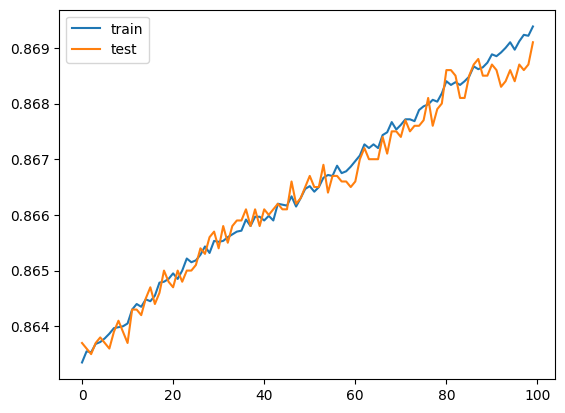

In [35]:
plot_acc(train_accs, test_accs)

tensor([[0.0000, 0.0000, 1.4221, 1.3079, 5.1363, 0.0000, 0.0000, 0.8269, 0.0000,
         1.8772]], device='cuda:0', grad_fn=<ReluBackward0>)
예측값 4
정답 4


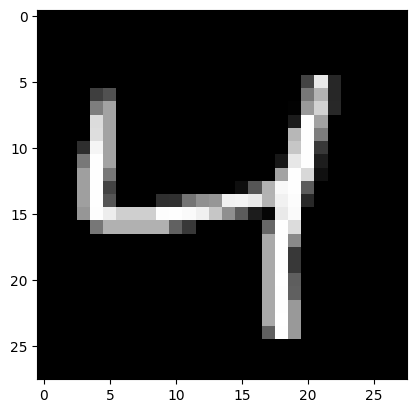

In [60]:
idx = 2

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')
output = model(x)
print(output)
predict_class = torch.argmax(output)
print("예측값",predict_class.item())
print("정답",trainset[idx][1])
image, label = trainset[idx]
plt.imshow(image[0], cmap='gray')

여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.